In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
path_No = r"/content/drive/MyDrive/Colab Notebooks/Brain_Tummor_Detection/no/*"
path_Yes = r"/content/drive/MyDrive/Colab Notebooks/Brain_Tummor_Detection/yes/*"

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      #Reading the images from the path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)

# Concatenating the two lists and shuffle the data
all_data = tumor + no_tumor


# Splitting data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

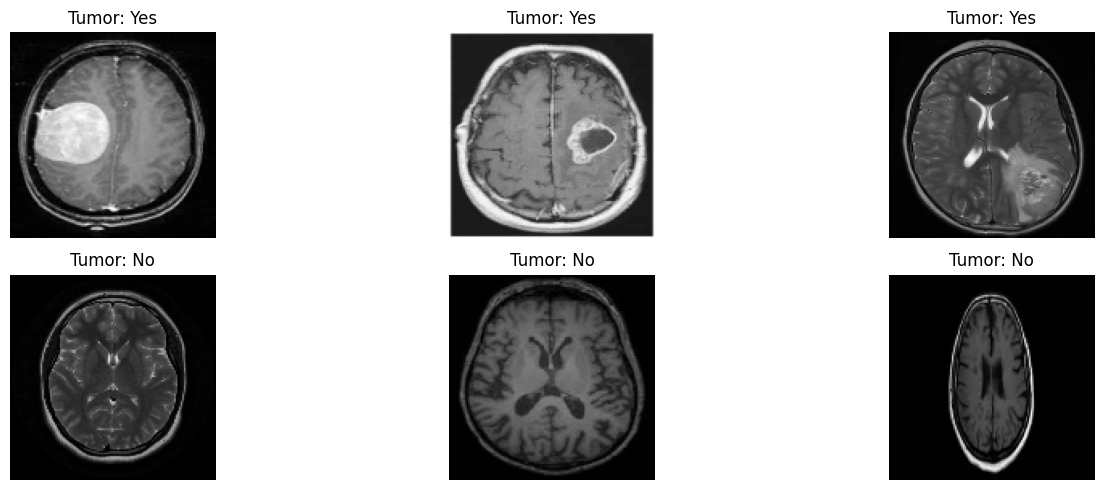

In [ ]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

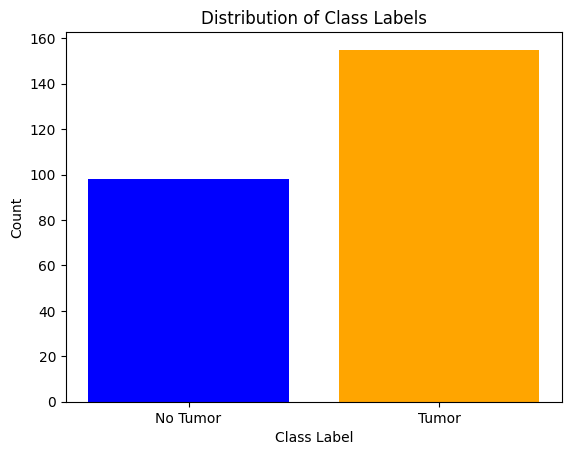

In [ ]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [ ]:
def crop_brain_region(image, size):

    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)

    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)

    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image

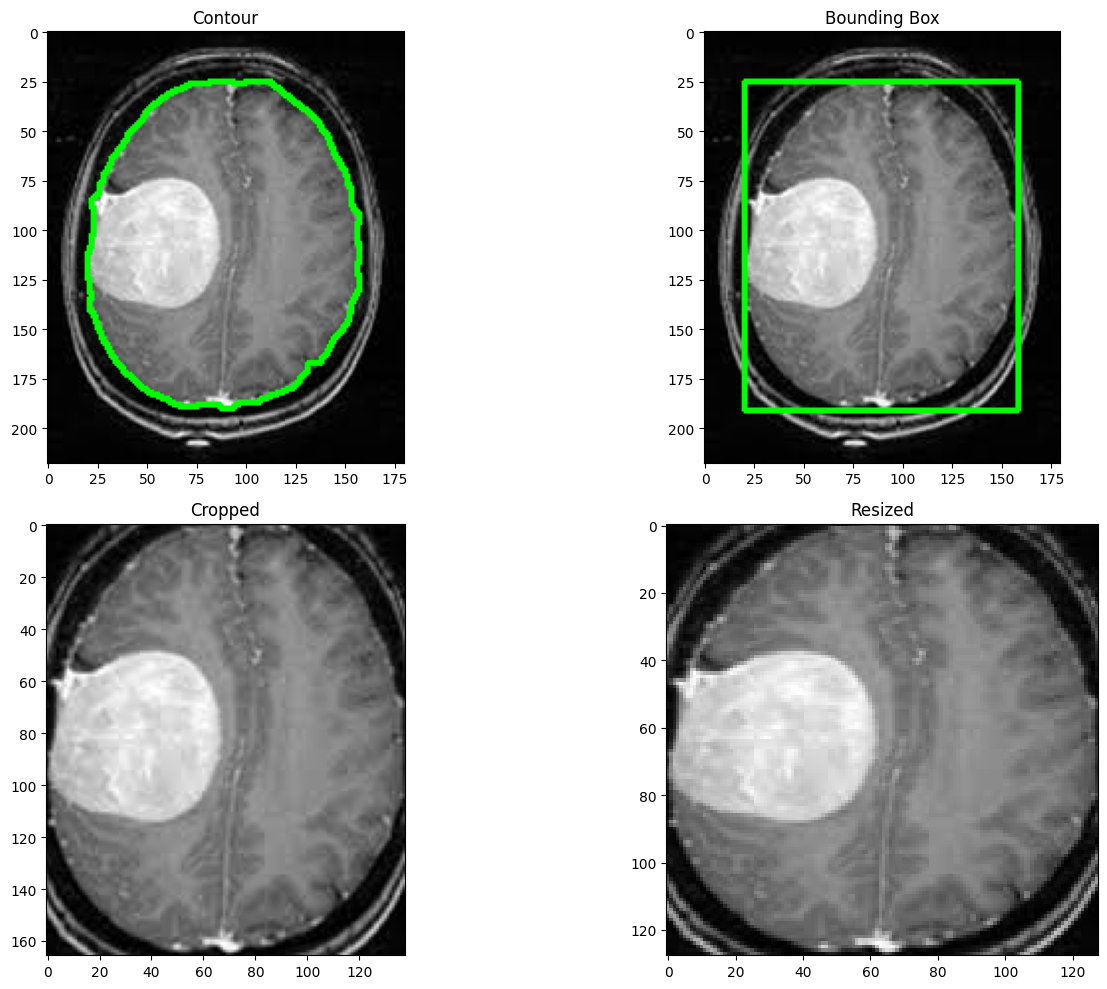

In [ ]:
output_size = (128, 128)

example_image = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/Brain_Tummor_Detection/yes/Y1.jpg")
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

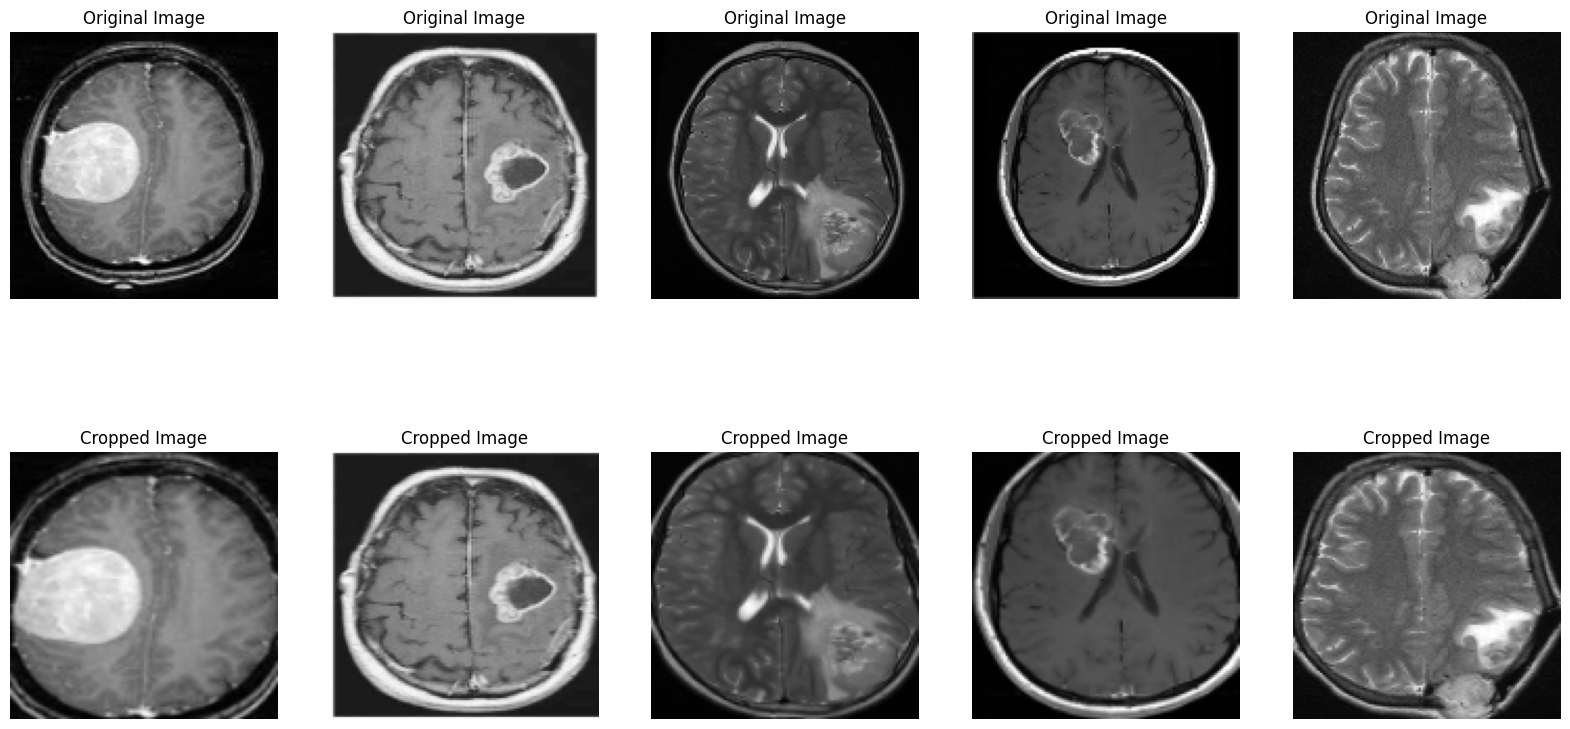

In [ ]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()


In [ ]:
all_cropped=np.array(all_cropped)

In [ ]:
all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (202, 128, 128, 3)
Train labels shape: (202,)
Validation data shape: (26, 128, 128, 3)
Validation labels shape: (26,)
Test data shape: (25, 128, 128, 3)
Test labels shape: (25,)


In [ ]:
print(np.max(train_images))
print(np.min(train_images))

255
0


In [ ]:
train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

In [ ]:
print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])


Epoch 1/50
7/7 [==============================] - 2s 55ms/step - loss: 0.6811 - accuracy: 0.5594 - val_loss: 0.6345 - val_accuracy: 0.6923
Epoch 2/50
7/7 [==============================] - 0s 26ms/step - loss: 0.6598 - accuracy: 0.6089 - val_loss: 0.6163 - val_accuracy: 0.6923
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.6629 - accuracy: 0.6089 - val_loss: 0.6165 - val_accuracy: 0.6923
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.6495 - accuracy: 0.6089 - val_loss: 0.6240 - val_accuracy: 0.6923
Epoch 5/50
7/7 [==============================] - 0s 22ms/step - loss: 0.6583 - accuracy: 0.6089 - val_loss: 0.6272 - val_accuracy: 0.6923
Epoch 6/50
7/7 [==============================] - 0s 27ms/step - loss: 0.6421 - accuracy: 0.6089 - val_loss: 0.6125 - val_accuracy: 0.6923
Epoch 7/50
7/7 [==============================] - 0s 27ms/step - loss: 0.6291 - accuracy: 0.6089 - val_loss: 0.5979 - val_accuracy: 0.6923
Epoch 8/50
7/7 [===========

1/1 [==============================] - 0s 72ms/step
Accuracy on Validation Set: 0.808 %


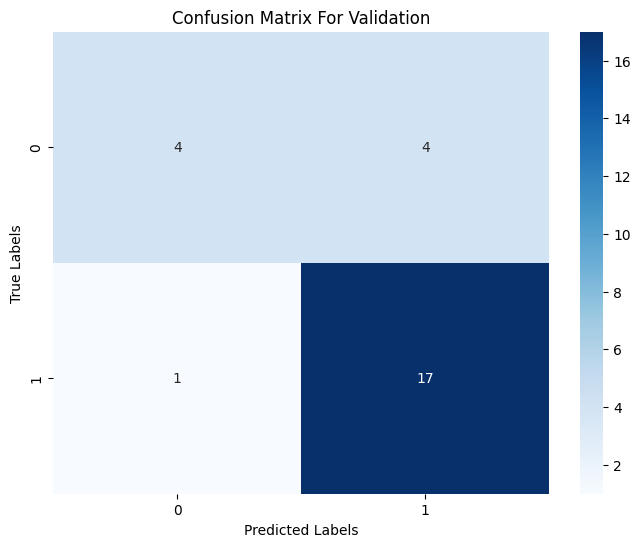

In [ ]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 20ms/step
Accuracy on Test Set: 0.880 %


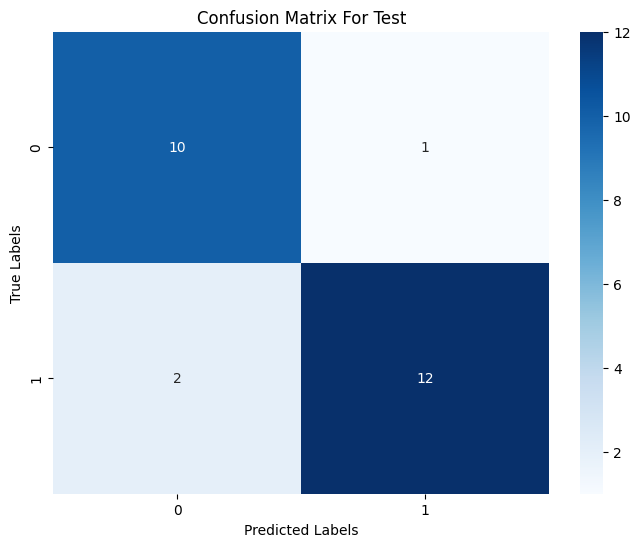

In [ ]:
predictions = model.predict(test_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

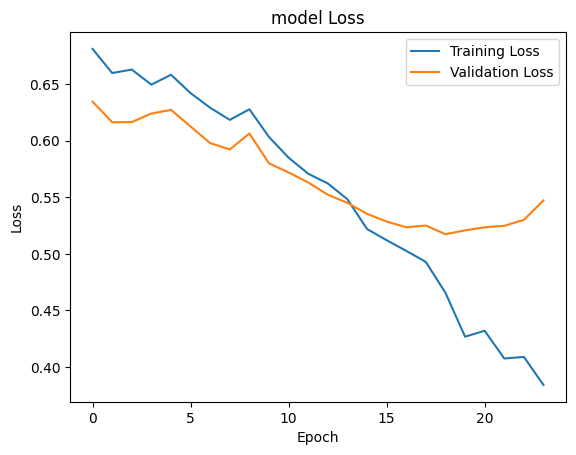

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

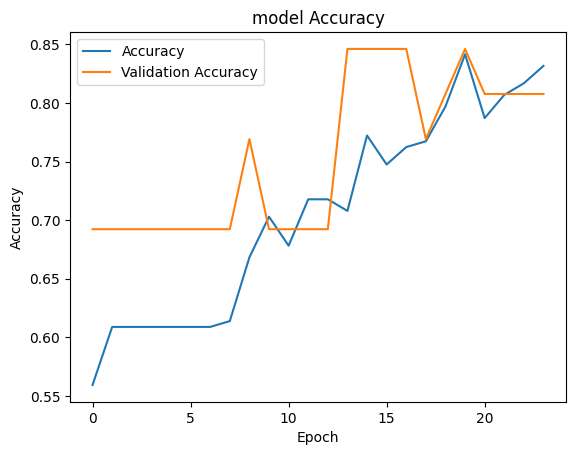

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,              # Random rotation by 0 to 20 degrees
    horizontal_flip=True,           # Random horizontal flipping
    vertical_flip=True,             # Random vertical flipping
    width_shift_range=0.1,          # Random width shifting by 10% of total width
    height_shift_range=0.1,         # Random height shifting by 10% of total height
    shear_range=0.1,                # Shear intensity by 0.1 radians
    zoom_range=0.1,                 # Random zooming by 10%
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    train_images, train_labels,
    batch_size=32
)

val_generator = val_datagen.flow(
    val_images, val_labels,
    batch_size=32
)

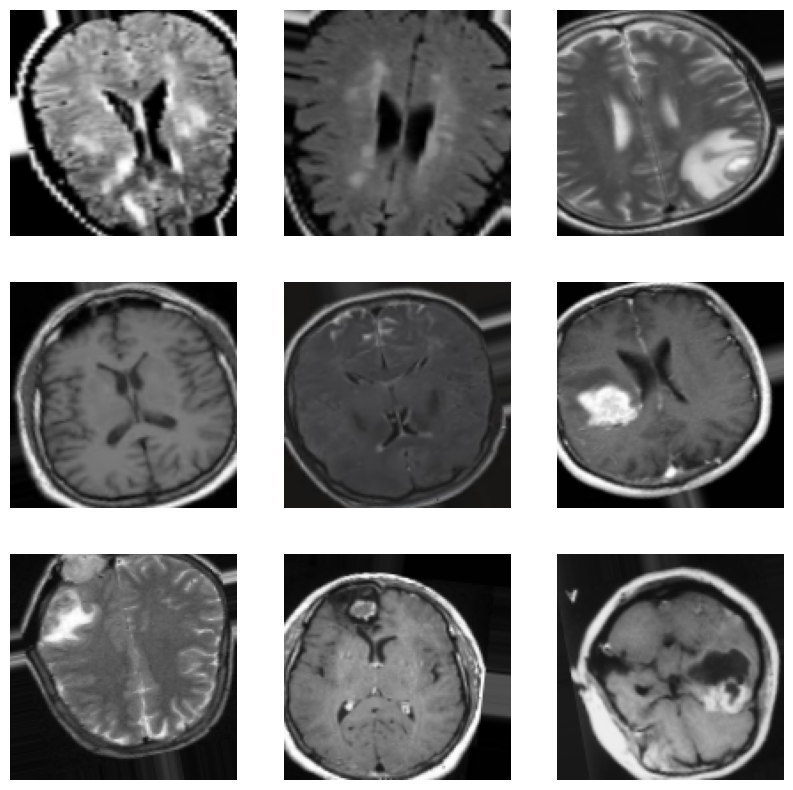

In [ ]:
augmented_images, _ = train_datagen.flow(train_images, train_labels, batch_size=32).next()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [ ]:
base_model = VGG16(weights=r"/content/drive/MyDrive/Colab Notebooks/Brain_Tummor_Detection/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(128, 128, 3))

base_model.layers[0].trainable = False


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

history = model.fit(train_generator,epochs=200,validation_data=val_generator,callbacks=[early_stopping, reduce_lr])

Epoch 1/200
7/7 [==============================] - 21s 1s/step - loss: 1.1675 - accuracy: 0.4208 - val_loss: 1.0259 - val_accuracy: 0.3077 - lr: 1.0000e-05
Epoch 2/200
7/7 [==============================] - 1s 163ms/step - loss: 1.0067 - accuracy: 0.4851 - val_loss: 0.8724 - val_accuracy: 0.7308 - lr: 1.0000e-05
Epoch 3/200
7/7 [==============================] - 1s 190ms/step - loss: 0.9573 - accuracy: 0.5347 - val_loss: 0.7924 - val_accuracy: 0.6923 - lr: 1.0000e-05
Epoch 4/200
7/7 [==============================] - 1s 167ms/step - loss: 0.9147 - accuracy: 0.5743 - val_loss: 0.7659 - val_accuracy: 0.7692 - lr: 1.0000e-05
Epoch 5/200
7/7 [==============================] - 1s 170ms/step - loss: 0.8592 - accuracy: 0.6040 - val_loss: 0.7409 - val_accuracy: 0.8077 - lr: 1.0000e-05
Epoch 6/200
7/7 [==============================] - 1s 166ms/step - loss: 0.8363 - accuracy: 0.6634 - val_loss: 0.6959 - val_accuracy: 0.7692 - lr: 1.0000e-05
Epoch 7/200
7/7 [==============================] - 2s 

1/1 [==============================] - 0s 146ms/step
Accuracy on Validation Set: 1.000000


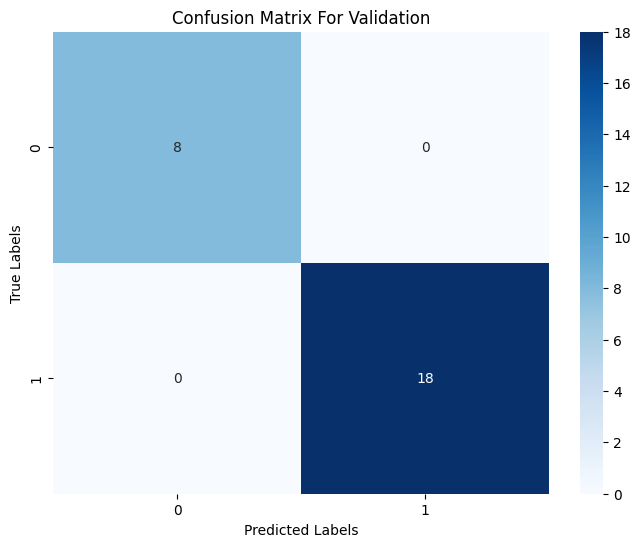

In [ ]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy on Test Set: 1.000000


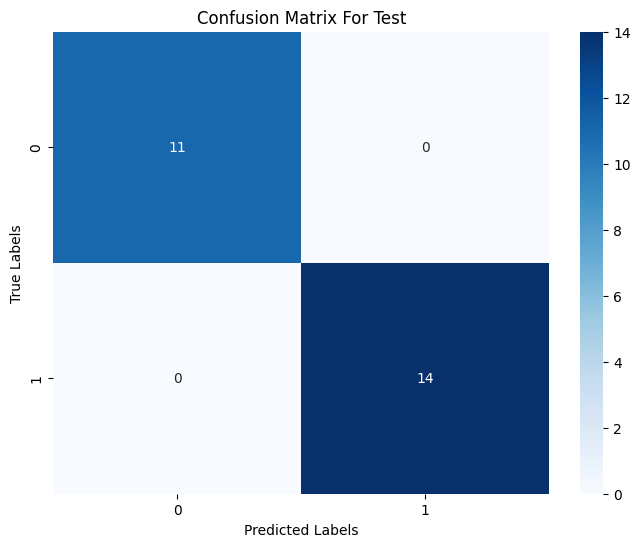

In [ ]:
predictions = model.predict(test_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

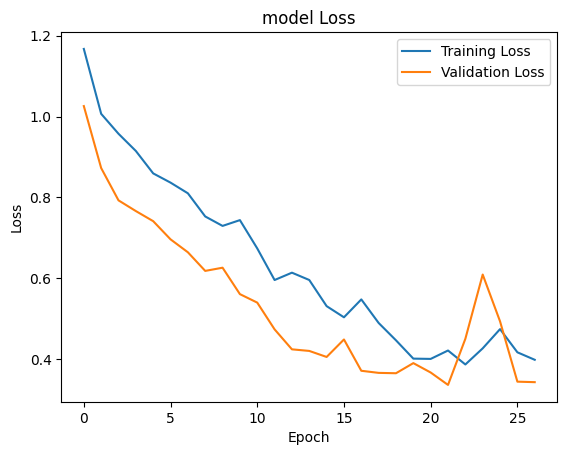

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

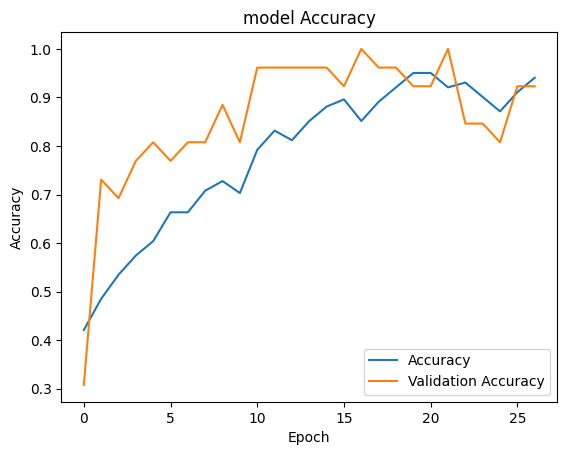

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
